----- Start glycan type analysis for NGlycoPep file. -----

----- Summarizing the glycan type composition within each site. -----

67
each_site_ind:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

each_glycan_type:['FA1', 'The core is not complete!', 'Man6', 'The core is not complete!', 'The core is not complete!', 'The core is not complete!', 'FA1', 'FA2/FA1B', 'The core is not complete!', 'A4/A3B', 'Man5', 'Man5', 'A1', 'Fhybrid', 'FA2/FA1B', 'Hybrid', 'A3/A2B', 'A4/A3B', 'A4/A3B', 'FA4/FA3B', 'The core is not complete!', 'The core is not complete!', 'The core is not complete!', 'Fhybrid', 'Hybrid', 'Hybrid', 'A2/A1B', 'FA3/FA2B', 'FA4/FA3B', 'FA4/FA3B', 'FA2/FA1B', 'Hybrid', 'Hybrid', 'The core is not complete!', 'Fhybrid', 'FA4/FA3B', 'A4/A3B']
this is glycan: FA1
final multi_highman:0

this is glycan: The core is not complete!
final multi_highman:0

this is glycan: Man6
final multi_highman:0

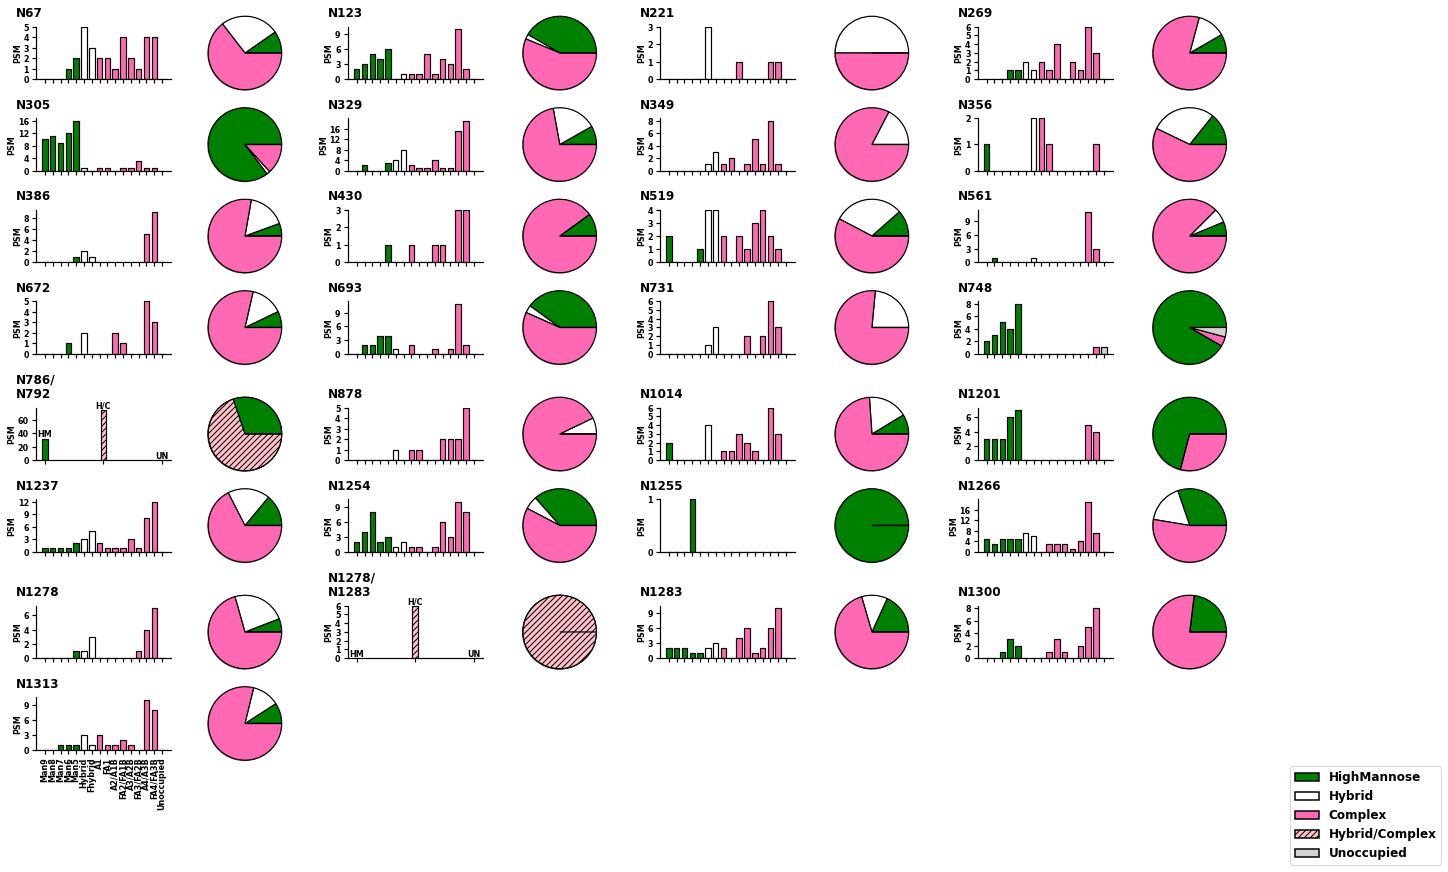

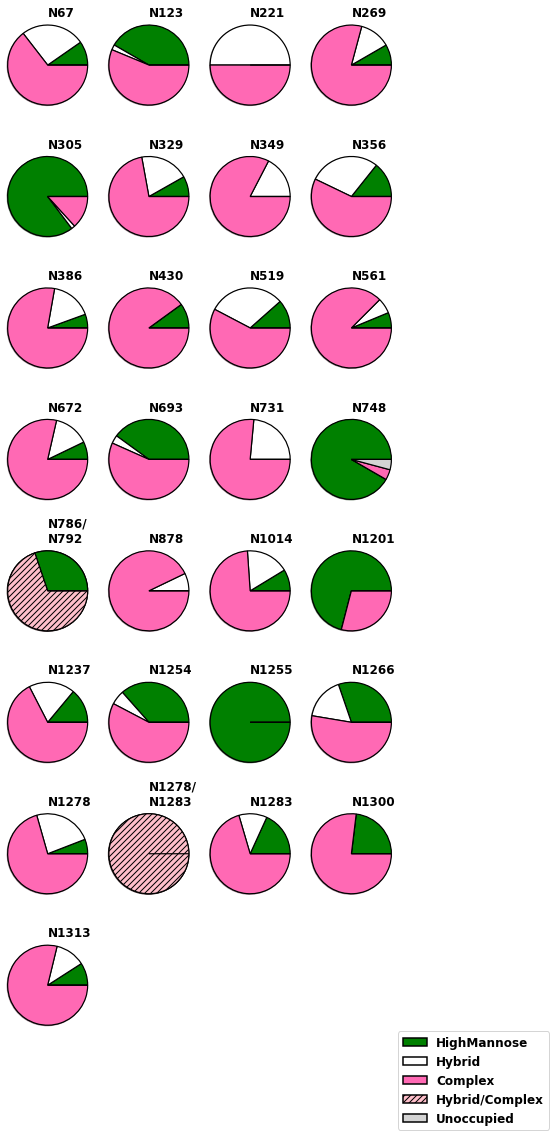

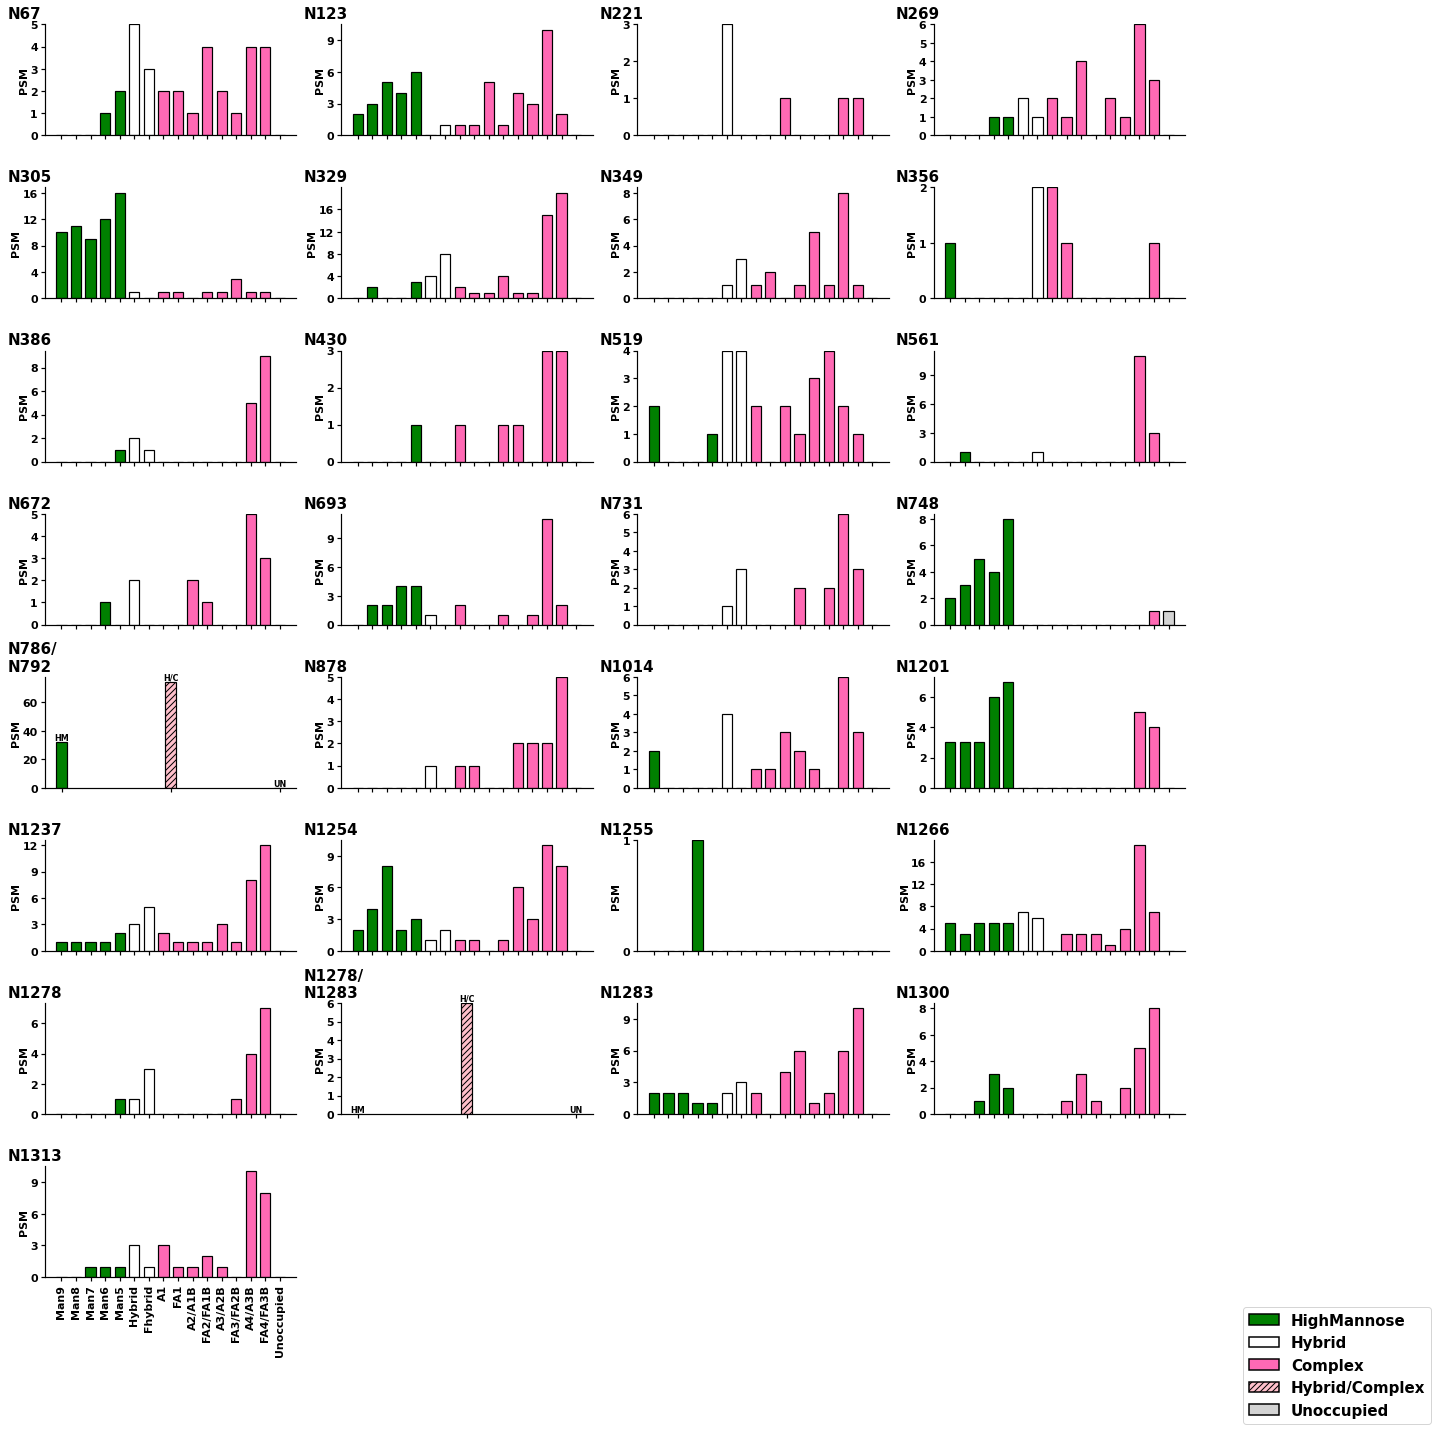

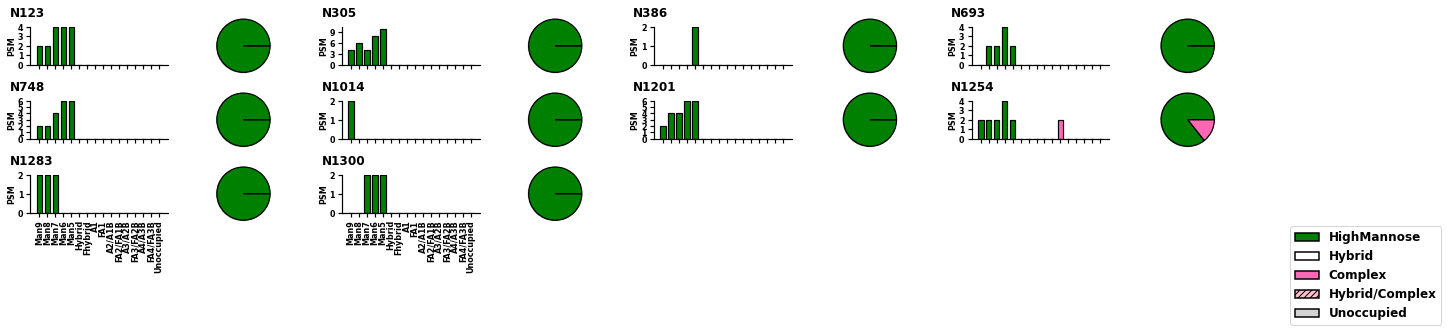

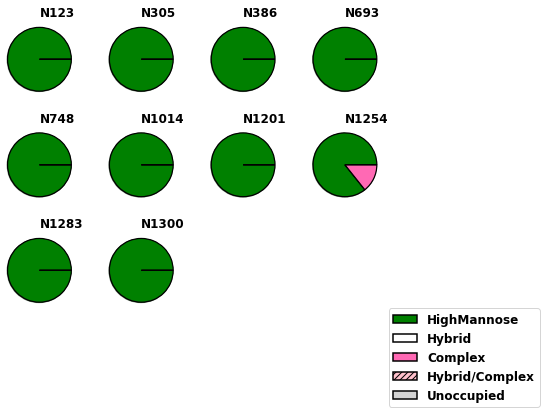

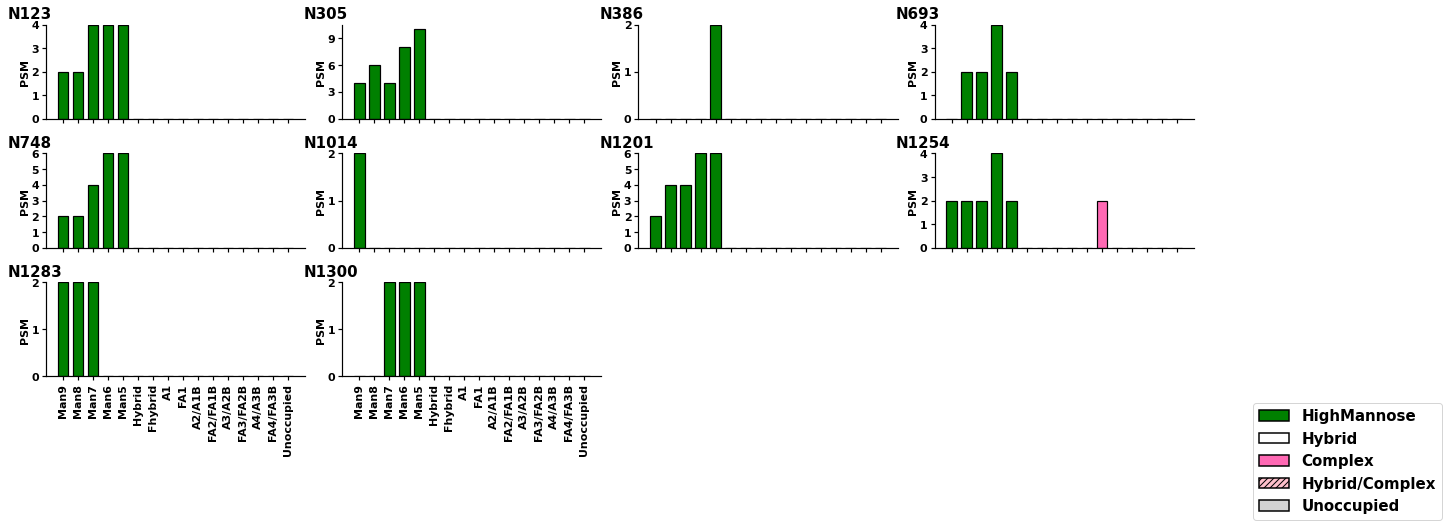

In [5]:
# THIS IS A PLUG-IN FOR _NGlycoPep FILE GLYCAN TYPE ANALYSIS
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import ticker
from IPython.display import display, HTML
import re # finding specific patterns in str
import textwrap # split text into equal parts
import collections # return repeated items in list
from collections import OrderedDict
import time
from datetime import datetime # attach current date to export filename
import sys
import ast # convert str back to tuple/list/int, etc

print('----- Start glycan type analysis for NGlycoPep file. -----\n')
# INPUT _NGlycoPep FILE
filename = '20210702_byonic_PEDV_NS_HEK_byos_PEDV_NS_HEK_pglyco_PEDV_HEK_NGlycoPep' # the filename has been changed to _NGlycoPep in newer version

############################### PLEASE DO NOT ALTER ANYTHING BELOW ###############################
# AUXILIARY FUNCTIONS
def move_df(df, move_col, insert_left_col):
    move_df = df[move_col]
    df.drop(labels=[move_col], axis=1, inplace = True)
    df.insert(df.columns.get_loc(insert_left_col) + 1, move_col, move_df)
# MAIN PROCESSING FUNCS
def GlycanTypeAnalysis(df, glycans_col, sequon_col, software=''): # INSERTS GLYCANTYPEANALYSIS COL TO DF
    N = df[glycans_col].str.findall(r'HexNAc\((\d+)\)')
    N = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in N]
    df['hexnac'] = N

    H = df[glycans_col].str.findall(r'Hex\((\d+)\)')
    H = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in H]
    df['hex'] = H

    F = df[glycans_col].str.findall(r'Fuc\((\d+)\)')
    F = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in F]
    df['fuc'] = F

    NA = df[glycans_col].str.findall(r'NeuAc\((\d+)\)')
    NA = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in NA]
    df['neuac'] = NA

    NG = df[glycans_col].str.findall(r'NeuGc\((\d+)\)')
    NG = [[sum(list(map(int, i)))] if type(i) == list else np.nan for i in NG]
    df['neugc'] = NG

    df['glycancode'] = df['hexnac'] + df['hex'] + df['fuc'] + df['neuac'] + df['neugc']
    df.loc[(df[glycans_col] == 'N/A'), 'glycancode'] = 'N/A'
    df.loc[(df[glycans_col] == -1), 'glycancode'] = -1

    # extract numbers in each glyco composition gp
    df['hexnac'] = [i[0] if type(i) == list else i for i in df['hexnac']]
    df['hex'] = [i[0] if type(i) == list else i for i in df['hex']]
    df['hex-hexnac'] = df['hex']-df['hexnac']
    df['fuc'] = [i[0] if type(i) == list else i for i in df['fuc']]
    df['neuac'] = [i[0] if type(i) == list else i for i in df['neuac']]
    df['neugc'] = [i[0] if type(i) == list else i for i in df['neugc']]

    # HIGHMAN (24000~29000)
    df.loc[(df['hexnac']==2)&(df['hex']<=9)&(df['hex']>=4), 'GlycanTypeAnalysis'] = 'Man'
    df['GlycanTypeAnalysis'] = df['GlycanTypeAnalysis'] + df['hex'].astype('Int64').astype(str)
    # ONLY CORE
    df.loc[(df['hexnac']==2)&(df['hex']==3), 'GlycanTypeAnalysis'] = 'Only core!'
    # THE CORE IS NOT COMPLETE
    df.loc[(df['hexnac']<2)|(df['hex']<3), 'GlycanTypeAnalysis'] = 'The core is not complete!' # any one of them is below 23000 composition could happen
    # PRECURSOR (>29000)
    df.loc[(df['hexnac']==2)&(df['hex']>9), 'GlycanTypeAnalysis'] = 'Potential N-glycan precursor'
    # MULTI-SITES
    # cannot form any core
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']<=2)|(df['hex']<3)), 'GlycanTypeAnalysis'] = 'Multi Site: Cannot form any core!' 
    # only 1 core
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==2)&(df['hex']==3)), 'GlycanTypeAnalysis'] = 'Multi Site: Only 1 core!' 
    # count psm once: highman
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==2)&(df['hex']>3)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM once]: Highmannose'
    # count psm once: hybrid/complex
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']>2)&(df['hex']>=3)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM once]: Hybrid/Complex'
    # 2 cores
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==4)&(df['hex']==6)), 'GlycanTypeAnalysis'] = 'Multi Site: 2 cores!'
    # count psm twice: highman
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']==4)&(df['hex']>6)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM twice]: Highmannose'
    # count psm twice: hybrid/complex
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, tuple)))&((df['hexnac']>4)&(df['hex']>=6)), 'GlycanTypeAnalysis'] = 'Multi Site [count PSM twice]: Hybrid/Complex'
    # SINGLE COMPLEX & HYBRID (REMEMBER TO CONSIDER FUCOSE)
    # single complex no f
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==3)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A1' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==4)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A2/A1B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==5)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A3/A2B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=6)&(df['hex-hexnac']<2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'A4/A3B' 
    # single complex w/ f 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==3)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA1' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==4)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA2/FA1B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']==5)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA3/FA2B' 
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=6)&(df['hex-hexnac']<2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'FA4/FA3B' 
    # single hybrid no f
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=3)&(df['hex-hexnac']>=2)&(df['fuc']==0)), 'GlycanTypeAnalysis'] = 'Hybrid' 
    # single hybrid w/ f
    df.loc[(df[sequon_col].apply(lambda x: isinstance(x, str)))&((df['hexnac']>=3)&(df['hex-hexnac']>=2)&(df['fuc']!=0)), 'GlycanTypeAnalysis'] = 'Fhybrid' 
    # UNOCCUPIED
    df.loc[(df[glycans_col]=='N/A'), 'GlycanTypeAnalysis'] = 'Unoccupied'
    # MISSING DATA
    df.loc[(df[glycans_col]==-1), 'GlycanTypeAnalysis'] = -1
    # DROP REDUNDANT COLS
    df = df.drop(['glycancode', 'hexnac', 'hex', 'fuc', 'neuac', 'neugc', 'hex-hexnac'], axis = 1)
    # RENAME COL FOR DIF SOFTWARE
    df = df.rename(columns={'GlycanTypeAnalysis':'GlycanTypeAnalysis%s'%(software)}) 
    # MOVE RESULT
    move_df(df, 'GlycanTypeAnalysis%s'%(software), glycans_col)
    df.to_excel('glycoform.xlsx', index = False)
    return df
def Plotter(df, glycantypecol, nsite_col, psm_col, software=''):
    # turn str back to tuple to sort
    df[nsite_col] = [ast.literal_eval(i) if type(i)==str else i for i in df[nsite_col]]
    # filter out missing data
    df = df.loc[df[glycantypecol]!=-1]
    # prepare key var
    glycosylation_site = df[nsite_col].tolist()
    glycan_analysis_result = df[glycantypecol].tolist()
    # sorted list set (non-repeated nsites, with single sites sorted before multi-site tuples)
    site_nostr_new = sorted(list(set(glycosylation_site)), key=lambda v: (isinstance(v, tuple), v))
    site_nostr_new = sorted(site_nostr_new, key=lambda x: x[0] if type(x)==tuple else x)
    psm = df[psm_col].tolist()

    bar_size = [] #length == site number.
    pie_size = [] #length == site number.
    for site in site_nostr_new: #loop thru non-repeated sites.
        print(site)
        each_bar_size = [] #length == 16.
        each_pie_size = [] #length == 4.
        man9, man8, man7, man6, man5, hybrid, fhybrid, a1, fa1, a2a1b, fa2fa1b, a3a2b, fa3fa2b, a4a3b, fa4fa3b, unoccupied, multi_highman, multi_complex_hybrid = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
        each_site_ind = [pos for pos, char in enumerate(glycosylation_site) if char == site]
        print('each_site_ind:%s\n'%each_site_ind)
        each_site_ind_cnt = 0
        each_glycan_type = [glycan_analysis_result[i] for i in each_site_ind] #all the glycan analysis results within one site (a list).
        print('each_glycan_type:%s'%each_glycan_type)
        for glycan in each_glycan_type:
            print('this is glycan: %s'%glycan)
            if glycan == 'Man9':
                man9 += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1 
            elif glycan == 'Man8':
                man8 += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'Man7':
                man7 += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'Man6':
                man6 += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'Man5':
                man5 += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'Man4': # do not plot man4
                each_site_ind_cnt += 1
            elif glycan == 'Hybrid':
                hybrid += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'Fhybrid':
                fhybrid += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'A1':
                a1 += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'FA1':
                fa1 += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'A2/A1B':
                a2a1b += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'FA2/FA1B':
                fa2fa1b += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'A3/A2B':
                a3a2b += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'FA3/FA2B':
                fa3fa2b += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'A4/A3B':
                a4a3b += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'FA4/FA3B':
                fa4fa3b += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'The core is not complete!':
                each_site_ind_cnt += 1
            elif glycan == 'Only core!':
                each_site_ind_cnt += 1
            elif glycan == 'Potential N-glycan precursor':
                each_site_ind_cnt += 1
            elif glycan == 'Multi Site: Only 1 core!':
                each_site_ind_cnt += 1
            elif glycan == 'Multi Site: Cannot form any core!':
                each_site_ind_cnt += 1
            elif glycan == 'Multi Site [count PSM once]: Highmannose':
                multi_highman += psm[each_site_ind[each_site_ind_cnt]] 
                each_site_ind_cnt += 1
            elif glycan == 'Multi Site [count PSM once]: Hybrid/Complex':
                multi_complex_hybrid += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            elif glycan == 'Multi Site: 2 cores!':
                each_site_ind_cnt += 1
            elif glycan == 'Multi Site [count PSM twice]: Highmannose':
                multi_highman += psm[each_site_ind[each_site_ind_cnt]]*2
                each_site_ind_cnt += 1
                print('multi_highman:%s\n'%multi_highman)
            elif glycan == 'Multi Site [count PSM twice]: Hybrid/Complex':
                multi_complex_hybrid += psm[each_site_ind[each_site_ind_cnt]]*2
                each_site_ind_cnt += 1
            elif glycan == 'Unoccupied': 
                unoccupied += psm[each_site_ind[each_site_ind_cnt]]
                each_site_ind_cnt += 1
            print('final multi_highman:%s\n'%multi_highman)
        if type(site) == tuple: # multi-sites (more than one sequon)
            each_bar_size.extend([multi_highman, multi_complex_hybrid, unoccupied])
            bar_size.append(each_bar_size)
            Highman = each_bar_size[0]
            Hybrid_Complex = each_bar_size[1]
            Unoccupied = each_bar_size[-1]
            each_pie_size.extend([Highman, Hybrid_Complex, Unoccupied])
            pie_size.append(each_pie_size)
        else: # real single sites (single sequon)
            each_bar_size.extend([man9, man8, man7, man6, man5, hybrid, fhybrid, a1, fa1, a2a1b, fa2fa1b, a3a2b, fa3fa2b, a4a3b, fa4fa3b, unoccupied])
            bar_size.append(each_bar_size)
            Highman = sum(each_bar_size[:5])
            Hybrid = sum(each_bar_size[5:7])
            Complex = sum(each_bar_size[7:15])
            Unoccupied = each_bar_size[-1]
            each_pie_size.extend([Highman, Hybrid, Complex, Unoccupied])
            pie_size.append(each_pie_size)
    print('this is bar_size:\n%s'%bar_size)
    original_bar_size = bar_size #save for later manipulation. 
    print('this is pie_size:\n%s'%pie_size)
    original_pie_size = pie_size #save for later manipulation.
    print('length of the bar_size (also the final site number): %s'%len(bar_size))
    print('length of the pie_size (also the final site number): %s'%len(pie_size))

    ##record glycosylation site indices.
    sites_for_plot = ['N%s'%site if type(site)==int else '/\n'.join(['N%s'%(site[i]) for i in range(len(site))]) for site in site_nostr_new]
    pie_types = ['HighMannose', 'Hybrid', 'Complex', 'Hybrid/Complex', 'Unoccupied']
    bar_types = ['Man9', 'Man8', 'Man7', 'Man6', 'Man5', 'Hybrid', 'Fhybrid', 'A1', 'FA1', 'A2/A1B', 'FA2/FA1B', 'A3/A2B', 'FA3/FA2B', 'A4/A3B', 'FA4/FA3B', 'Unoccupied']
    multi_bar_types = ['HighMannose', 'Hybrid/Complex', 'Unoccupied']
    colors = ['#008000', '#ffffff','#ff69b4','#d3d3d3'] 
    multi_colors = ['#008000', '#ffc0cb', '#d3d3d3']
    leg_colors = ['#008000', '#ffffff','#ff69b4', '#ffc0cb', '#d3d3d3']

    ##start plotting.
    ## PLOT BAR & PIE COMBINED CHARTS FIRST.
    ##### adjustable parameters ###################
    if len(bar_size) <= 4:
        number_of_sites_inrow = 1
        full_row_num = len(bar_size)//number_of_sites_inrow
        remainder_num = len(bar_size)%number_of_sites_inrow
        bar_remainder = bar_size[-remainder_num:] #last ones.
        print('bar_remainder: %s'%bar_remainder)
        bar_size = [bar_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
        pie_remainder = pie_size[-remainder_num:] #last ones.
        print('pie_remainder: %s'%pie_remainder)
        pie_size = [pie_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
        print('this is resized bar_size: %s'%bar_size)
        print('this is resized pie_size: %s'%pie_size)
    else:
        number_of_sites_inrow = 4
        full_row_num = len(bar_size)//number_of_sites_inrow
        remainder_num = len(bar_size)%number_of_sites_inrow
        bar_remainder = bar_size[-remainder_num:] #last ones.
        print('bar_remainder: %s'%bar_remainder)
        bar_size = [bar_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
        bar_size.append(bar_remainder)
        pie_remainder = pie_size[-remainder_num:] #last ones.
        print('pie_remainder: %s'%pie_remainder)
        pie_size = [pie_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
        pie_size.append(pie_remainder)
        print('this is resized bar_size: %s'%bar_size)
        print('this is resized pie_size: %s'%pie_size)

    if remainder_num == 0:
        row_num = full_row_num
    else: 
        row_num = full_row_num + 1

    print('this is row_num: %s'%row_num)
    print('this is remainder_num: %s'%remainder_num)
    col_num = 2*number_of_sites_inrow
    fig_ratio = number_of_sites_inrow/row_num
    ###############################################

    #make everything in the plot bold & basic setups.
    ####### fontsize & spine width #######
    bar_title_fontsize = 12
    bar_title_ha = 'left'
    SUBPLOT_PAD = 10
    bar_ylab_fontsize = bar_title_fontsize - 4
    bar_width = 0.7
    multi_bar_width = 0.1
    x_tick_fontsize = bar_title_fontsize -4 
    y_tick_fonsize = bar_title_fontsize -4
    x_tick_w = 1.2
    x_tick_l = x_tick_w*3
    y_tick_w = 1.2
    y_tick_l = y_tick_w*3
    spine_width = 1.2
    pie_line_w = 1.2
    bar_line_w = pie_line_w
    legend_fontsize = bar_title_fontsize
    legend_handleL = 2
    MULTI_SITE_BAR_FONT_SIZE = 8
    MULTI_SITE_BAR_LABEL_PAD = 0
    PSM_LABEL_PAD = 1.5
    PIE_R = 1.75
    HATCH = '/'*4
    TICKER_THRESHOLD = 6
    MAXNLOCATOR_NBINS = 5
    COMBINED_PLOTS_RATIO_1 = 5
    COMBINED_PLOTS_RATIO_2 = 1.5
    ######################################
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    fig, axs = plt.subplots(nrows=row_num, ncols=col_num, figsize=(COMBINED_PLOTS_RATIO_1*number_of_sites_inrow, COMBINED_PLOTS_RATIO_2*row_num), constrained_layout=True)
    site_name_count = 0

    if row_num >1: 
        for i in range(row_num):
            if i != (row_num -1): #other than the last row. 
                for j in range(number_of_sites_inrow): #N sites from left to right.
                    if max(bar_size[i][j]) > TICKER_THRESHOLD: #use ticker.
                        if '/' in sites_for_plot[site_name_count]: #multi-sites.
                            #pie
                            axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                            axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                            #bar
                            axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                            axs[i, 2*j].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[i, 2*j].spines[spine].set_visible(False)
                            index = [i for i in range(3)]
                            xticks = np.arange(3)
                            #yticks = np.arange(max(size[i])+1)
                            axs[i, 2*j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                            axs[i, 2*j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[i, 2*j].title.set_position([-0.15, 1.1])
                            axs[i, 2*j].set_xticks(xticks, minor=False)
                            axs[i, 2*j].set_xticklabels('')
                            #axs[i, 2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'center', fontsize = x_tick_fontsize)
                            #ax1.set_yticks(yticks, minor=False)
                            #ax1.set_ylim(yticks[0], yticks[-1])
                            axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            bars = [rect for rect in axs[i, 2*j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                            print('this is the length of bars: %s'%len(bars))
                            bar_type_count = 0
                            multi_bar_labels = ['HM', 'H/C', 'UN']
                            for bar in bars:
                                if bar_type_count != 3: 
                                    height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                    label_x_pos = bar.get_x() + bar.get_width() / 2
                                    axs[i, 2*j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                    va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                    bar_type_count += 1
                                else:
                                    pass
                            site_name_count += 1
                        else: #real singel sites.
                            #pie
                            axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                            #bar
                            axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                            axs[i, 2*j].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[i, 2*j].spines[spine].set_visible(False)
                            index = [i for i in range(16)]
                            xticks = np.arange(16)
                            #yticks = np.arange(max(size[i])+1)
                            axs[i, 2*j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[i, 2*j].title.set_position([-0.15, 1.1])
                            axs[i, 2*j].set_xticks(xticks, minor=False)
                            axs[i, 2*j].set_xticklabels('')
                            #ax1.set_yticks(yticks, minor=False)
                            #ax1.set_ylim(yticks[0], yticks[-1])
                            axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            site_name_count += 1
                    else: #do not use ticker.
                        if '/' in sites_for_plot[site_name_count]: #multi-sites.
                            #pie
                            axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                            axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                            #bar
                            axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            #yticks = ticker.MaxNLocator(6)
                            #axs[i, 2*j].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[i, 2*j].spines[spine].set_visible(False)
                            index = [i for i in range(3)]
                            xticks = np.arange(3)
                            yticks = np.arange(max(bar_size[i][j])+1)
                            axs[i, 2*j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                            axs[i, 2*j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[i, 2*j].title.set_position([-0.15, 1.1])
                            axs[i, 2*j].set_xticks(xticks, minor=False)
                            axs[i, 2*j].set_xticklabels('')
                            #axs[i, 2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'center', fontsize = x_tick_fontsize)
                            axs[i, 2*j].set_yticks(yticks, minor=False)
                            axs[i, 2*j].set_ylim(yticks[0], yticks[-1])
                            axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            bars = [rect for rect in axs[i, 2*j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                            print('this is the length of bars: %s'%len(bars))
                            bar_type_count = 0
                            multi_bar_labels = ['HM', 'H/C', 'UN']
                            for bar in bars:
                                if bar_type_count != 3: 
                                    height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD 
                                    label_x_pos = bar.get_x() + bar.get_width() / 2
                                    axs[i, 2*j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                    va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                    bar_type_count += 1
                                else:
                                    pass
                            site_name_count += 1
                        else: #real singel sites.
                            #pie
                            axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                            #bar
                            axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            #yticks = ticker.MaxNLocator(6)
                            #axs[i, 2*j].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[i, 2*j].spines[spine].set_visible(False)
                            index = [i for i in range(16)]
                            xticks = np.arange(16)
                            yticks = np.arange(max(bar_size[i][j])+1)
                            axs[i, 2*j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[i, 2*j].title.set_position([-0.15, 1.1])
                            axs[i, 2*j].set_xticks(xticks, minor=False)
                            axs[i, 2*j].set_xticklabels('')
                            axs[i, 2*j].set_yticks(yticks, minor=False)
                            axs[i, 2*j].set_ylim(yticks[0], yticks[-1])
                            axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            site_name_count += 1
            else: #for the last row. Deal with the remainder.
                if remainder_num == 0: #can be divided by 4.
                    last_row_site_num = number_of_sites_inrow
                else: #cannot be divided by 4.
                    last_row_site_num = remainder_num
                print('this is last_row_site_num: %s'%last_row_site_num)
                for j in range(number_of_sites_inrow):
                    if j < last_row_site_num:  
                        print('this is i,j: %s,%s'%(i,j))
                        if max(bar_size[i][j]) > TICKER_THRESHOLD: #use ticker.
                            if '/' in sites_for_plot[site_name_count]: #multi-sites.
                                #pie
                                axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                                axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                                #bar
                                axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                                axs[i, 2*j].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, 2*j].spines[spine].set_visible(False)
                                index = [i for i in range(3)]
                                xticks = np.arange(3)
                                #yticks = np.arange(max(size[i])+1)
                                axs[i, 2*j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                                axs[i, 2*j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, 2*j].title.set_position([-0.15, 1.1])
                                axs[i, 2*j].set_xticks(xticks, minor=False)
                                axs[i, 2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                                #ax1.set_yticks(yticks, minor=False)
                                #ax1.set_ylim(yticks[0], yticks[-1])
                                axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                bars = [rect for rect in axs[i, 2*j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                                print('this is the length of bars: %s'%len(bars))
                                bar_type_count = 0
                                multi_bar_labels = ['HM', 'H/C', 'UN']
                                for bar in bars:
                                    if bar_type_count != 3: 
                                        height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                        label_x_pos = bar.get_x() + bar.get_width() / 2
                                        axs[i, 2*j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                        va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                        bar_type_count += 1
                                    else:
                                        pass
                                site_name_count += 1
                            else: #real single sites.
                                #pie
                                axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                                #bar
                                axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                                axs[i, 2*j].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, 2*j].spines[spine].set_visible(False)
                                index = [i for i in range(16)]
                                xticks = np.arange(16)
                                #yticks = np.arange(max(size[i])+1)
                                axs[i, 2*j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, 2*j].title.set_position([-0.15, 1.1])
                                axs[i, 2*j].set_xticks(xticks, minor=False)
                                axs[i, 2*j].set_xticklabels( bar_types, fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                                #ax1.set_yticks(yticks, minor=False)
                                #ax1.set_ylim(yticks[0], yticks[-1])
                                axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                site_name_count += 1
                        else: #do not use ticker.
                            if '/' in sites_for_plot[site_name_count]: #multi-sites.
                                #pie
                                axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                                axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                                #bar
                                axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                #yticks = ticker.MaxNLocator(6)
                                #axs[i, 2*j].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, 2*j].spines[spine].set_visible(False)
                                index = [i for i in range(3)]
                                xticks = np.arange(3)
                                yticks = np.arange(max(bar_size[i][j])+1)
                                axs[i, 2*j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                                axs[i, 2*j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, 2*j].title.set_position([-0.15, 1.1])
                                axs[i, 2*j].set_xticks(xticks, minor=False)
                                axs[i, 2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                                axs[i, 2*j].set_yticks(yticks, minor=False)
                                axs[i, 2*j].set_ylim(yticks[0], yticks[-1])
                                axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                bars = [rect for rect in axs[i, 2*j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                                print('this is the length of bars: %s'%len(bars))
                                bar_type_count = 0
                                multi_bar_labels = ['HM', 'H/C', 'UN']
                                for bar in bars:
                                    if bar_type_count != 3: 
                                        height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                        label_x_pos = bar.get_x() + bar.get_width() / 2
                                        axs[i, 2*j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                        va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                        bar_type_count += 1
                                    else:
                                        pass
                                site_name_count += 1
                            else: #real single sites.
                                print('this is i,j: %s,%s'%(i,j))
                                #pie
                                axs[i, 2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                                #bar
                                axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                #yticks = ticker.MaxNLocator(6)
                                #axs[i, 0].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, 2*j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, 2*j].spines[spine].set_visible(False)
                                index = [i for i in range(16)]
                                xticks = np.arange(16)
                                yticks = np.arange(max(bar_size[i][j])+1)
                                axs[i, 2*j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, 2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, 2*j].title.set_position([-0.15, 1.1])
                                axs[i, 2*j].set_xticks(xticks, minor=False)
                                axs[i, 2*j].set_xticklabels(bar_types , fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                                axs[i, 2*j].set_yticks(yticks, minor=False)
                                axs[i, 2*j].set_ylim(yticks[0], yticks[-1])
                                axs[i, 2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                site_name_count += 1
                    else: #empty subplot(s). hide spines & ticks & labels.
                        print('this is i,j for empty subplots: %s,%s'%(i,j))
                        axs[i, 2*j].spines["left"].set_visible(False)
                        axs[i, 2*j].spines["right"].set_visible(False)
                        axs[i, 2*j].spines["top"].set_visible(False)
                        axs[i, 2*j].spines["bottom"].set_visible(False)
                        axs[i, 2*j+1].spines["left"].set_visible(False)
                        axs[i, 2*j+1].spines["right"].set_visible(False)
                        axs[i, 2*j+1].spines["top"].set_visible(False)
                        axs[i, 2*j+1].spines["bottom"].set_visible(False)
                        axs[i, 2*j].xaxis.set_ticks([])
                        axs[i, 2*j].yaxis.set_ticks([])
                        axs[i, 2*j+1].xaxis.set_ticks([])
                        axs[i, 2*j+1].yaxis.set_ticks([])
    else: #if only one row. (based on the layout setting above, this will happen if there's only one site.)
        i = 0
        if remainder_num == 0: #can be divided by 4.
            last_row_site_num = number_of_sites_inrow
        else: #cannot be divided by 4.
            last_row_site_num = remainder_num
        print('this is last_row_site_num: %s'%last_row_site_num)
        for j in range(number_of_sites_inrow):
            if j < last_row_site_num:  
                if max(bar_size[i][j]) > TICKER_THRESHOLD: #use ticker.
                    if '/' in sites_for_plot[site_name_count]: #multi-sites.
                        #pie
                        axs[2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                        axs[2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                        #bar
                        axs[2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                        axs[2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                        yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                        axs[2*j].yaxis.set_major_locator(yticks)
                        for axis in ["left", 'bottom']:
                            axs[2*j].spines[axis].set_linewidth(spine_width)
                        for spine in ["top", "right"]:
                            axs[2*j].spines[spine].set_visible(False)
                        index = [i for i in range(3)]
                        xticks = np.arange(3)
                        #yticks = np.arange(max(size[i])+1)
                        axs[2*j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                        axs[2*j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                        axs[2*j].title.set_position([-0.15, 1.1])
                        axs[2*j].set_xticks(xticks, minor=False)
                        axs[2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                        #ax1.set_yticks(yticks, minor=False)
                        #ax1.set_ylim(yticks[0], yticks[-1])
                        axs[2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                        bars = [rect for rect in axs[2*j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                        print('this is the length of bars: %s'%len(bars))
                        bar_type_count = 0
                        multi_bar_labels = ['HM', 'H/C', 'UN']
                        for bar in bars:
                            if bar_type_count != 3: 
                                height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                label_x_pos = bar.get_x() + bar.get_width() / 2
                                axs[2*j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                bar_type_count += 1
                            else:
                                pass
                        site_name_count += 1
                    else: #real single sites.
                        #pie
                        axs[2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                        #bar
                        axs[2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                        axs[2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                        yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                        axs[2*j].yaxis.set_major_locator(yticks)
                        for axis in ["left", 'bottom']:
                            axs[2*j].spines[axis].set_linewidth(spine_width)
                        for spine in ["top", "right"]:
                            axs[2*j].spines[spine].set_visible(False)
                        index = [i for i in range(16)]
                        xticks = np.arange(16)
                        #yticks = np.arange(max(size[i])+1)
                        axs[2*j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                        axs[2*j].title.set_position([-0.15, 1.1])
                        axs[2*j].set_xticks(xticks, minor=False)
                        axs[2*j].set_xticklabels( bar_types, fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                        #ax1.set_yticks(yticks, minor=False)
                        #ax1.set_ylim(yticks[0], yticks[-1])
                        axs[2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                        site_name_count += 1
                else: #do not use ticker.
                    if '/' in sites_for_plot[site_name_count]: #multi-sites.
                        #pie
                        axs[2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                        axs[2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                        #bar
                        axs[i, 2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                        axs[i, 2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                        #yticks = ticker.MaxNLocator(6)
                        #axs[i, 2*j].yaxis.set_major_locator(yticks)
                        for axis in ["left", 'bottom']:
                            axs[2*j].spines[axis].set_linewidth(spine_width)
                        for spine in ["top", "right"]:
                            axs[2*j].spines[spine].set_visible(False)
                        index = [i for i in range(3)]
                        xticks = np.arange(3)
                        yticks = np.arange(max(bar_size[i][j])+1)
                        axs[2*j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                        axs[2*j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                        axs[2*j].title.set_position([-0.15, 1.1])
                        axs[2*j].set_xticks(xticks, minor=False)
                        axs[2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                        axs[2*j].set_yticks(yticks, minor=False)
                        axs[2*j].set_ylim(yticks[0], yticks[-1])
                        axs[2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                        bars = [rect for rect in axs[2*j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                        print('this is the length of bars: %s'%len(bars))
                        bar_type_count = 0
                        multi_bar_labels = ['HM', 'H/C', 'UN']
                        for bar in bars:
                            if bar_type_count != 3: 
                                height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                label_x_pos = bar.get_x() + bar.get_width() / 2
                                axs[2*j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                bar_type_count += 1
                            else:
                                pass
                        site_name_count += 1
                    else: #real single sites.
                        print('this is i,j: %s,%s'%(i,j))
                        #pie
                        axs[2*j+1].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                        #bar
                        axs[2*j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                        axs[2*j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                        #yticks = ticker.MaxNLocator(6)
                        #axs[i, 0].yaxis.set_major_locator(yticks)
                        for axis in ["left", 'bottom']:
                            axs[2*j].spines[axis].set_linewidth(spine_width)
                        for spine in ["top", "right"]:
                            axs[2*j].spines[spine].set_visible(False)
                        index = [i for i in range(16)]
                        xticks = np.arange(16)
                        yticks = np.arange(max(bar_size[i][j])+1)
                        axs[2*j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                        axs[2*j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                        axs[2*j].title.set_position([-0.15, 1.1])
                        axs[2*j].set_xticks(xticks, minor=False)
                        axs[2*j].set_xticklabels(bar_types , fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                        axs[2*j].set_yticks(yticks, minor=False)
                        axs[2*j].set_ylim(yticks[0], yticks[-1])
                        axs[2*j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                        site_name_count += 1
            else: #empty subplot(s). hide spines & ticks & labels.
                print('this is i,j for empty subplots: %s,%s'%(i,j))
                axs[2*j].spines["left"].set_visible(False)
                axs[2*j].spines["right"].set_visible(False)
                axs[2*j].spines["top"].set_visible(False)
                axs[2*j].spines["bottom"].set_visible(False)
                axs[2*j+1].spines["left"].set_visible(False)
                axs[2*j+1].spines["right"].set_visible(False)
                axs[2*j+1].spines["top"].set_visible(False)
                axs[2*j+1].spines["bottom"].set_visible(False)
                axs[2*j].xaxis.set_ticks([])
                axs[2*j].yaxis.set_ticks([])
                axs[2*j+1].xaxis.set_ticks([])
                axs[2*j+1].yaxis.set_ticks([])


    params = {'legend.fontsize': legend_fontsize, 'legend.handlelength': legend_handleL}
    legend_properties = {'weight':'bold'}
    plt.rcParams.update(params)

    legend_elements = []
    for i in range(len(leg_colors)):
        if i == 3:
            each_line = Patch(facecolor = leg_colors[i], edgecolor = 'k', label = pie_types[i], lw = 1.5, hatch = HATCH)
            legend_elements.append(each_line)
        else:
            each_line = Patch(facecolor = leg_colors[i], edgecolor = 'k', label = pie_types[i], lw = 1.5)
            legend_elements.append(each_line)


    plt.legend(handles=legend_elements, prop=legend_properties, bbox_to_anchor=(1.2,-0.2), loc='upper left')

    #plt.tight_layout()
    print('\nExport Pie & Bar charts as .png files.')
    fig.savefig(f'{date}_{filename}_{software}BarPieCharts.png')

    ## DRAW ALL PIE CHARTS (if site num > 4).
    if len(original_pie_size) > 4: 
    ##### adjustable parameters ###################
    #if len(original_pie_size) < 4:
    #    number_of_sites_inrow = 1
    #    full_row_num = len(original_pie_size)//number_of_sites_inrow
    #    remainder_num = len(original_pie_size)%number_of_sites_inrow
    #    pie_remainder = original_pie_size[-remainder_num:] #last ones.
    #    print('pie_remainder: %s'%pie_remainder)
    #    pie_size = [original_pie_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
    #    print('this is resized pie_size: %s'%pie_size)
    #else:
        number_of_sites_inrow = 4
        full_row_num = len(original_pie_size)//number_of_sites_inrow
        remainder_num = len(original_pie_size)%number_of_sites_inrow
        pie_remainder = original_pie_size[-remainder_num:] #last ones.
        print('pie_remainder: %s'%pie_remainder)
        pie_size = [original_pie_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
        pie_size.append(pie_remainder)
        print('this is resized pie_size: %s'%pie_size)

        if remainder_num == 0:
            row_num = full_row_num
        else: #e.g. 3 sites in total.
            row_num = full_row_num + 1

        print('this is row_num: %s'%row_num)
        print('this is remainder_num: %s'%remainder_num)
        col_num = 1*number_of_sites_inrow
        fig_ratio = number_of_sites_inrow/row_num
        ###############################################

        #make everything in the plot bold & basic setups.
        ####### fontsize & spine width #######
        pie_title_fontsize = 12
        SUBPLOT_PAD = 20
        pie_line_w = 1.2
        legend_fontsize = bar_title_fontsize
        legend_handleL = 2
        PIE_R = 1.75
        HATCH = '/'*4
        PIE_PLOTS_RATIO_1 = 2
        PIE_PLOTS_RATIO_2 = 2
        ######################################
        fig, axs = plt.subplots(nrows=row_num, ncols=col_num, figsize=(PIE_PLOTS_RATIO_1*number_of_sites_inrow, PIE_PLOTS_RATIO_2*row_num), constrained_layout=False)
        site_name_count = 0

        if row_num >1: 
            for i in range(row_num):
                if i != (row_num -1): #other than the last row. 
                    for j in range(number_of_sites_inrow): #N sites from left to right.
                        if '/' in sites_for_plot[site_name_count]: #multi-sites.
                            #pie
                            axs[i, j].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                            axs[i, j].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                            axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            site_name_count += 1
                        else: #real singel sites.
                            #pie
                            axs[i, j].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                            axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            site_name_count += 1
                else: #for the last row. Deal with the remainder.
                    if remainder_num == 0: #can be divided by 8.
                        last_row_site_num = number_of_sites_inrow
                    else: #cannot be divided by 8.
                        last_row_site_num = remainder_num
                    print('this is last_row_site_num: %s'%last_row_site_num)
                    for j in range(number_of_sites_inrow):
                        if j < last_row_site_num:  
                            print('this is i,j: %s,%s'%(i,j))
                            if '/' in sites_for_plot[site_name_count]: #multi-sites.
                                #pie
                                axs[i, j].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                                axs[i, j].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                                axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                site_name_count += 1
                            else: #real single sites.
                                #pie
                                axs[i, j].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                                axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                site_name_count += 1       
                        else: #empty subplot(s). hide spines & ticks & labels.
                            print('this is i,j for empty subplots: %s,%s'%(i,j))
                            axs[i, j].spines["left"].set_visible(False)
                            axs[i, j].spines["right"].set_visible(False)
                            axs[i, j].spines["top"].set_visible(False)
                            axs[i, j].spines["bottom"].set_visible(False)
                            axs[i, j].xaxis.set_ticks([])
                            axs[i, j].yaxis.set_ticks([])
        else: #if only one row. (based on the layout setting above, this will happen if there's only one site.)
            i = 0
            if remainder_num == 0: #can be divided by 8.
                last_row_site_num = number_of_sites_inrow
            else: #cannot be divided by 8.
                last_row_site_num = remainder_num
            print('this is last_row_site_num: %s'%last_row_site_num)
            for j in range(number_of_sites_inrow):
                if j < last_row_site_num:
                    if '/' in sites_for_plot[site_name_count]: #multi-sites.
                        #pie
                        axs[j].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                        axs[j].pie(pie_size[i][j], radius=PIE_R, colors = multi_colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})[0][1].set_hatch(HATCH)
                        axs[j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                        site_name_count += 1
                    else: #real single sites.
                        #pie
                        axs[j].pie(pie_size[i][j], radius=PIE_R, colors = colors, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': pie_line_w, 'antialiased': True})
                        axs[j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                        site_name_count += 1
                else: #empty subplot(s). hide spines & ticks & labels.
                    axs[j].spines["left"].set_visible(False)
                    axs[j].spines["right"].set_visible(False)
                    axs[j].spines["top"].set_visible(False)
                    axs[j].spines["bottom"].set_visible(False)
                    axs[j].xaxis.set_ticks([])
                    axs[j].yaxis.set_ticks([])

        params = {'legend.fontsize': legend_fontsize, 'legend.handlelength': legend_handleL}
        legend_properties = {'weight':'bold'}
        plt.rcParams.update(params)

        legend_elements = []
        for i in range(len(leg_colors)):
            if i == 3:
                each_line = Patch(facecolor = leg_colors[i], edgecolor = 'k', label = pie_types[i], lw = 1.5, hatch = HATCH)
                legend_elements.append(each_line)
            else:
                each_line = Patch(facecolor = leg_colors[i], edgecolor = 'k', label = pie_types[i], lw = 1.5)
                legend_elements.append(each_line)

        plt.legend(handles=legend_elements, prop=legend_properties, bbox_to_anchor=(1.2,-0.2), loc='upper left')

        plt.tight_layout()
        print('\nExport All Pie charts as .png')
        fig.savefig(f'{date}_{filename}_{software}PieCharts.png')


        ## DRAW ALL BAR CHARTS (if site num > 4). 
        ##### adjustable parameters ###################
        #if len(original_bar_size) < 4:
        #    number_of_sites_inrow = 1
        #    full_row_num = len(original_bar_size)//number_of_sites_inrow
        #    remainder_num = len(original_bar_size)%number_of_sites_inrow
        #    bar_remainder = original_bar_size[-remainder_num:] #last ones.
        #    print('bar_remainder: %s'%bar_remainder)
        #    bar_size = [original_bar_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
        #    print('this is resized bar_size: %s'%bar_size)
        #else:
        number_of_sites_inrow = 4
        full_row_num = len(original_bar_size)//number_of_sites_inrow
        remainder_num = len(original_bar_size)%number_of_sites_inrow
        bar_remainder = original_bar_size[-remainder_num:] #last ones.
        print('bar_remainder: %s'%bar_remainder)
        bar_size = [original_bar_size[number_of_sites_inrow*i:number_of_sites_inrow*(i+1)] for i in range(full_row_num)]
        bar_size.append(bar_remainder)
        print('this is resized bar_size: %s'%bar_size)

        if remainder_num == 0:
            row_num = full_row_num
        else: #e.g. 3 sites in total.
            row_num = full_row_num + 1

        print('this is row_num: %s'%row_num)
        print('this is remainder_num: %s'%remainder_num)
        col_num = 1*number_of_sites_inrow
        fig_ratio = number_of_sites_inrow/row_num
        ###############################################

        #make everything in the plot bold & basic setups.
        ####### fontsize & spine width #######
        bar_title_fontsize = 15
        SUBPLOT_PAD = 6
        bar_ylab_fontsize = bar_title_fontsize - 4
        bar_width = 0.7
        multi_bar_width = 0.1
        x_tick_fontsize = bar_title_fontsize -4 
        y_tick_fonsize = bar_title_fontsize -4
        x_tick_w = 1.2
        x_tick_l = x_tick_w*3
        y_tick_w = 1.2
        y_tick_l = y_tick_w*3
        spine_width = 1.2
        pie_line_w = 1.2
        legend_fontsize = bar_title_fontsize
        legend_handleL = 2
        MULTI_SITE_BAR_FONT_SIZE = 8
        MULTI_SITE_BAR_LABEL_PAD = 0
        PSM_LABEL_PAD = 1.5
        PIE_R = 1.75
        HATCH = '////'
        TICKER_THRESHOLD = 6
        MAXNLOCATOR_NBINS = 5
        BAR_PLOTS_RATIO_1 = 5
        BAR_PLOTS_RATIO_2 = 2.5
        ######################################
        plt.rcParams["font.weight"] = "bold"
        plt.rcParams["axes.labelweight"] = "bold"
        fig, axs = plt.subplots(nrows=row_num, ncols=col_num, figsize=(BAR_PLOTS_RATIO_1*number_of_sites_inrow, BAR_PLOTS_RATIO_2*row_num), constrained_layout=False)
        site_name_count = 0

        if row_num >1: 
            for i in range(row_num):
                if i != (row_num -1): #other than the last row. 
                    for j in range(number_of_sites_inrow): #N sites from left to right.
                        if max(bar_size[i][j]) > TICKER_THRESHOLD: #use ticker.
                            if '/' in sites_for_plot[site_name_count]: #multi-sites.
                                #bar
                                axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                                axs[i, j].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, j].spines[spine].set_visible(False)
                                index = [i for i in range(3)]
                                xticks = np.arange(3)
                                #yticks = np.arange(max(size[i])+1)
                                axs[i, j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                                axs[i, j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, j].title.set_position([-0.15, 1.1])
                                axs[i, j].set_xticks(xticks, minor=False)
                                axs[i, j].set_xticklabels('')
                                #axs[i, 2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'center', fontsize = x_tick_fontsize)
                                #ax1.set_yticks(yticks, minor=False)
                                #ax1.set_ylim(yticks[0], yticks[-1])
                                axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                bars = [rect for rect in axs[i, j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                                print('this is the length of bars: %s'%len(bars))
                                bar_type_count = 0
                                multi_bar_labels = ['HM', 'H/C', 'UN']
                                for bar in bars:
                                    if bar_type_count != 3: 
                                        height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                        label_x_pos = bar.get_x() + bar.get_width() / 2
                                        axs[i, j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                        va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                        bar_type_count += 1
                                    else:
                                        pass
                                site_name_count += 1
                            else: #real singel sites.
                                #bar
                                axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                                axs[i, j].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, j].spines[spine].set_visible(False)
                                index = [i for i in range(16)]
                                xticks = np.arange(16)
                                #yticks = np.arange(max(size[i])+1)
                                axs[i, j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, j].title.set_position([-0.15, 1.1])
                                axs[i, j].set_xticks(xticks, minor=False)
                                axs[i, j].set_xticklabels('')
                                #ax1.set_yticks(yticks, minor=False)
                                #ax1.set_ylim(yticks[0], yticks[-1])
                                axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                site_name_count += 1
                        else: #do not use ticker.
                            if '/' in sites_for_plot[site_name_count]: #multi-sites.
                                #bar
                                axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                #yticks = ticker.MaxNLocator(6)
                                #axs[i, 2*j].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, j].spines[spine].set_visible(False)
                                index = [i for i in range(3)]
                                xticks = np.arange(3)
                                yticks = np.arange(max(bar_size[i][j])+1)
                                axs[i, j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                                axs[i, j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, j].title.set_position([-0.15, 1.1])
                                axs[i, j].set_xticks(xticks, minor=False)
                                axs[i, j].set_xticklabels('')
                                #axs[i, 2*j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'center', fontsize = x_tick_fontsize)
                                axs[i, j].set_yticks(yticks, minor=False)
                                axs[i, j].set_ylim(yticks[0], yticks[-1])
                                axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                bars = [rect for rect in axs[i, j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                                print('this is the length of bars: %s'%len(bars))
                                bar_type_count = 0
                                multi_bar_labels = ['HM', 'H/C', 'UN']
                                for bar in bars:
                                    if bar_type_count != 3: 
                                        height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD 
                                        label_x_pos = bar.get_x() + bar.get_width() / 2
                                        axs[i, j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                        va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                        bar_type_count += 1
                                    else:
                                        pass
                                site_name_count += 1
                            else: #real singel sites.
                                #bar
                                axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                #yticks = ticker.MaxNLocator(6)
                                #axs[i, 2*j].yaxis.set_major_locator(yticks)
                                for axis in ["left", 'bottom']:
                                    axs[i, j].spines[axis].set_linewidth(spine_width)
                                for spine in ["top", "right"]:
                                    axs[i, j].spines[spine].set_visible(False)
                                index = [i for i in range(16)]
                                xticks = np.arange(16)
                                yticks = np.arange(max(bar_size[i][j])+1)
                                axs[i, j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                axs[i, j].title.set_position([-0.15, 1.1])
                                axs[i, j].set_xticks(xticks, minor=False)
                                axs[i, j].set_xticklabels('')
                                axs[i, j].set_yticks(yticks, minor=False)
                                axs[i, j].set_ylim(yticks[0], yticks[-1])
                                axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                site_name_count += 1
                else: #for the last row. Deal with the remainder.
                    if remainder_num == 0: #can be divided by 8.
                        last_row_site_num = number_of_sites_inrow
                    else: #cannot be divided by 8.
                        last_row_site_num = remainder_num
                    print('this is last_row_site_num: %s'%last_row_site_num)
                    for j in range(number_of_sites_inrow):
                        if j < last_row_site_num:  
                            print('this is i,j: %s,%s'%(i,j))
                            if max(bar_size[i][j]) > TICKER_THRESHOLD: #use ticker.
                                if '/' in sites_for_plot[site_name_count]: #multi-sites.
                                    #bar
                                    axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                    axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                    yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                                    axs[i, j].yaxis.set_major_locator(yticks)
                                    for axis in ["left", 'bottom']:
                                        axs[i, j].spines[axis].set_linewidth(spine_width)
                                    for spine in ["top", "right"]:
                                        axs[i, j].spines[spine].set_visible(False)
                                    index = [i for i in range(3)]
                                    xticks = np.arange(3)
                                    #yticks = np.arange(max(size[i])+1)
                                    axs[i, j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                                    axs[i, j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                    axs[i, j].title.set_position([-0.15, 1.1])
                                    axs[i, j].set_xticks(xticks, minor=False)
                                    axs[i, j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                                    #ax1.set_yticks(yticks, minor=False)
                                    #ax1.set_ylim(yticks[0], yticks[-1])
                                    axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                    bars = [rect for rect in axs[i, 2*j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                                    print('this is the length of bars: %s'%len(bars))
                                    bar_type_count = 0
                                    multi_bar_labels = ['HM', 'H/C', 'UN']
                                    for bar in bars:
                                        if bar_type_count != 3: 
                                            height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                            label_x_pos = bar.get_x() + bar.get_width() / 2
                                            axs[i, j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                            va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                            bar_type_count += 1
                                        else:
                                            pass
                                    site_name_count += 1
                                else: #real single sites.
                                    #bar
                                    axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                    axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                    yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                                    axs[i, j].yaxis.set_major_locator(yticks)
                                    for axis in ["left", 'bottom']:
                                        axs[i, j].spines[axis].set_linewidth(spine_width)
                                    for spine in ["top", "right"]:
                                        axs[i, j].spines[spine].set_visible(False)
                                    index = [i for i in range(16)]
                                    xticks = np.arange(16)
                                    #yticks = np.arange(max(size[i])+1)
                                    axs[i, j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                    axs[i, j].title.set_position([-0.15, 1.1])
                                    axs[i, j].set_xticks(xticks, minor=False)
                                    axs[i, j].set_xticklabels( bar_types, fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                                    #ax1.set_yticks(yticks, minor=False)
                                    #ax1.set_ylim(yticks[0], yticks[-1])
                                    axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                    site_name_count += 1
                            else: #do not use ticker.
                                if '/' in sites_for_plot[site_name_count]: #multi-sites.
                                    #bar
                                    axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                    axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                    #yticks = ticker.MaxNLocator(6)
                                    #axs[i, 2*j].yaxis.set_major_locator(yticks)
                                    for axis in ["left", 'bottom']:
                                        axs[i, j].spines[axis].set_linewidth(spine_width)
                                    for spine in ["top", "right"]:
                                        axs[i, j].spines[spine].set_visible(False)
                                    index = [i for i in range(3)]
                                    xticks = np.arange(3)
                                    yticks = np.arange(max(bar_size[i][j])+1)
                                    axs[i, j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                                    axs[i, j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                    axs[i, j].title.set_position([-0.15, 1.1])
                                    axs[i, j].set_xticks(xticks, minor=False)
                                    axs[i, j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                                    axs[i, j].set_yticks(yticks, minor=False)
                                    axs[i, j].set_ylim(yticks[0], yticks[-1])
                                    axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                    bars = [rect for rect in axs[i, j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                                    print('this is the length of bars: %s'%len(bars))
                                    bar_type_count = 0
                                    multi_bar_labels = ['HM', 'H/C', 'UN']
                                    for bar in bars:
                                        if bar_type_count != 3: 
                                            height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                            label_x_pos = bar.get_x() + bar.get_width() / 2
                                            axs[i, j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                            va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                            bar_type_count += 1
                                        else:
                                            pass
                                    site_name_count += 1
                                else: #real single sites.
                                    print('this is i,j: %s,%s'%(i,j))
                                    #bar
                                    axs[i, j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                                    axs[i, j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                                    #yticks = ticker.MaxNLocator(6)
                                    #axs[i, 0].yaxis.set_major_locator(yticks)
                                    for axis in ["left", 'bottom']:
                                        axs[i, j].spines[axis].set_linewidth(spine_width)
                                    for spine in ["top", "right"]:
                                        axs[i, j].spines[spine].set_visible(False)
                                    index = [i for i in range(16)]
                                    xticks = np.arange(16)
                                    yticks = np.arange(max(bar_size[i][j])+1)
                                    axs[i, j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                                    axs[i, j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                                    axs[i, j].title.set_position([-0.15, 1.1])
                                    axs[i, j].set_xticks(xticks, minor=False)
                                    axs[i, j].set_xticklabels(bar_types , fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                                    axs[i, j].set_yticks(yticks, minor=False)
                                    axs[i, j].set_ylim(yticks[0], yticks[-1])
                                    axs[i, j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                                    site_name_count += 1
                        else: #empty subplot(s). hide spines & ticks & labels.
                            print('this is i,j for empty subplots: %s,%s'%(i,j))
                            axs[i, j].spines["left"].set_visible(False)
                            axs[i, j].spines["right"].set_visible(False)
                            axs[i, j].spines["top"].set_visible(False)
                            axs[i, j].spines["bottom"].set_visible(False)
                            axs[i, j].xaxis.set_ticks([])
                            axs[i, j].yaxis.set_ticks([])
        else: #if only one row. (based on the layout setting above, this will happen if there's only one site.)
            i = 0
            if remainder_num == 0: #can be divided by 4.
                last_row_site_num = number_of_sites_inrow
            else: #cannot be divided by 4.
                last_row_site_num = remainder_num
            print('this is last_row_site_num: %s'%last_row_site_num)
            for j in range(number_of_sites_inrow):
                if j < last_row_site_num:  
                    if max(bar_size[i][j]) > TICKER_THRESHOLD: #use ticker.
                        if '/' in sites_for_plot[site_name_count]: #multi-sites.
                            #bar
                            axs[j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                            axs[j].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[j].spines[spine].set_visible(False)
                            index = [i for i in range(3)]
                            xticks = np.arange(3)
                            #yticks = np.arange(max(size[i])+1)
                            axs[j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                            axs[j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[j].title.set_position([-0.15, 1.1])
                            axs[j].set_xticks(xticks, minor=False)
                            axs[j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                            #ax1.set_yticks(yticks, minor=False)
                            #ax1.set_ylim(yticks[0], yticks[-1])
                            axs[j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            bars = [rect for rect in axs[j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                            print('this is the length of bars: %s'%len(bars))
                            bar_type_count = 0
                            multi_bar_labels = ['HM', 'H/C', 'UN']
                            for bar in bars:
                                if bar_type_count != 3: 
                                    height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                    label_x_pos = bar.get_x() + bar.get_width() / 2
                                    axs[j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                    va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                    bar_type_count += 1
                                else:
                                    pass
                            site_name_count += 1
                        else: #real single sites.
                            #bar
                            axs[j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            yticks = ticker.MaxNLocator(MAXNLOCATOR_NBINS, integer = True)
                            axs[j].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[j].spines[spine].set_visible(False)
                            index = [i for i in range(16)]
                            xticks = np.arange(16)
                            #yticks = np.arange(max(size[i])+1)
                            axs[j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[j].title.set_position([-0.15, 1.1])
                            axs[j].set_xticks(xticks, minor=False)
                            axs[j].set_xticklabels( bar_types, fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                            #ax1.set_yticks(yticks, minor=False)
                            #ax1.set_ylim(yticks[0], yticks[-1])
                            axs[j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            site_name_count += 1
                    else: #do not use ticker.
                        if '/' in sites_for_plot[site_name_count]: #multi-sites.
                            #bar
                            axs[j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            #yticks = ticker.MaxNLocator(6)
                            #axs[i, 2*j].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[j].spines[spine].set_visible(False)
                            index = [i for i in range(3)]
                            xticks = np.arange(3)
                            yticks = np.arange(max(bar_size[i][j])+1)
                            axs[j].bar(index[0], bar_size[i][j][0], multi_bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[1], bar_size[i][j][1], multi_bar_width, color=['#ffc0cb'], edgecolor='black', linewidth = bar_line_w, hatch=HATCH)
                            axs[j].bar(index[2], bar_size[i][j][2], multi_bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[j].title.set_position([-0.15, 1.1])
                            axs[j].set_xticks(xticks, minor=False)
                            axs[j].set_xticklabels(multi_bar_types , fontweight="bold" ,minor=False, rotation = 45, ha = 'right', fontsize = x_tick_fontsize)
                            axs[j].set_yticks(yticks, minor=False)
                            axs[j].set_ylim(yticks[0], yticks[-1])
                            axs[j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            bars = [rect for rect in axs[j].get_children() if isinstance(rect, mpl.patches.Rectangle)]
                            print('this is the length of bars: %s'%len(bars))
                            bar_type_count = 0
                            multi_bar_labels = ['HM', 'H/C', 'UN']
                            for bar in bars:
                                if bar_type_count != 3: 
                                    height = bar.get_height() + MULTI_SITE_BAR_LABEL_PAD
                                    label_x_pos = bar.get_x() + bar.get_width() / 2
                                    axs[j].text(label_x_pos, height, s=multi_bar_labels[bar_type_count], ha='center',
                                    va='bottom', fontsize = MULTI_SITE_BAR_FONT_SIZE)
                                    bar_type_count += 1
                                else:
                                    pass
                            site_name_count += 1
                        else: #real single sites.
                            print('this is i,j: %s,%s'%(i,j))
                            #bar
                            axs[j].xaxis.set_tick_params(width=x_tick_w, length=x_tick_l)
                            axs[j].yaxis.set_tick_params(width=y_tick_w, length=y_tick_l, labelsize = y_tick_fonsize)
                            #yticks = ticker.MaxNLocator(6)
                            #axs[i, 0].yaxis.set_major_locator(yticks)
                            for axis in ["left", 'bottom']:
                                axs[j].spines[axis].set_linewidth(spine_width)
                            for spine in ["top", "right"]:
                                axs[j].spines[spine].set_visible(False)
                            index = [i for i in range(16)]
                            xticks = np.arange(16)
                            yticks = np.arange(max(bar_size[i][j])+1)
                            axs[j].bar(index[0:5], bar_size[i][j][0:5], bar_width, color=['#008000'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[5:7], bar_size[i][j][5:7], bar_width, color=['#ffffff'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[7:15], bar_size[i][j][7:15], bar_width, color=['#ff69b4'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].bar(index[15], bar_size[i][j][15], bar_width, color=['#d3d3d3'], edgecolor='black', linewidth = bar_line_w)
                            axs[j].set_title(sites_for_plot[site_name_count], size = bar_title_fontsize, fontweight="bold", pad = SUBPLOT_PAD, ha=bar_title_ha)
                            axs[j].title.set_position([-0.15, 1.1])
                            axs[j].set_xticks(xticks, minor=False)
                            axs[j].set_xticklabels(bar_types , fontweight="bold" ,minor=False, rotation = 90, ha = 'center', fontsize = x_tick_fontsize)
                            axs[j].set_yticks(yticks, minor=False)
                            axs[j].set_ylim(yticks[0], yticks[-1])
                            axs[j].set_ylabel("PSM", fontsize = bar_ylab_fontsize, fontweight="bold", labelpad = PSM_LABEL_PAD)
                            site_name_count += 1
                else: #empty subplot(s). hide spines & ticks & labels.
                    print('this is i,j for empty subplots: %s,%s'%(i,j))
                    axs[j].spines["left"].set_visible(False)
                    axs[j].spines["right"].set_visible(False)
                    axs[j].spines["top"].set_visible(False)
                    axs[j].spines["bottom"].set_visible(False)
                    axs[j].xaxis.set_ticks([])
                    axs[j].yaxis.set_ticks([])


        params = {'legend.fontsize': legend_fontsize, 'legend.handlelength': legend_handleL}
        legend_properties = {'weight':'bold'}
        plt.rcParams.update(params)

        legend_elements = []
        for i in range(len(leg_colors)):
            if i == 3:
                each_line = Patch(facecolor = leg_colors[i], edgecolor = 'k', label = pie_types[i], lw = 1.5, hatch = HATCH)
                legend_elements.append(each_line)
            else:
                each_line = Patch(facecolor = leg_colors[i], edgecolor = 'k', label = pie_types[i], lw = 1.5)
                legend_elements.append(each_line)


        plt.legend(handles=legend_elements, prop=legend_properties, bbox_to_anchor=(1.2,-0.2), loc='upper left')

        plt.tight_layout()
        print('\nExport All Bar charts as .png')
        fig.savefig(f'{date}_{filename}_{software}BarCharts.png')

# TIMESTAMP
start_time = time.time()
# FILE PREPROCESSING
df = pd.read_excel('%s.xlsx'%filename, header = 0)
df = df.fillna('N/A')
fixed_colname = [i.replace('_x000D_', '\r') if '_x000D_' in i else i for i in df.columns]
df.columns = fixed_colname
# RECORD DATE TODAY
date = datetime.now().strftime('%Y%m%d')
# COLUMN NAMES IN DIF INPUT FILE COMBO (2 situations: single/double processing)
if 'Glycans' in df.columns.tolist(): # only b
    glycans_col = 'Glycans'
    sequon_col = 'Sequon'
    site_col = 'N-site(SequonBased)'
elif 'GlycanComposition_ByonicStyle' in df.columns.tolist(): # only p
    glycans_col = 'GlycanComposition_ByonicStyle'
    sequon_col = 'Sequon'
    site_col = 'ProSites'
elif 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' not in df.columns.tolist(): # byonic + byos
    glycans_col = 'Glycans[Byonic]'
    sequon_col = 'Sequon[Byonic]'
    site_col = 'N-site(SequonBased)[Byonic]'
else: # bp all present
    b_glycans_col = 'Glycans[Byonic]'
    p_glycans_col = 'GlycanComposition_ByonicStyle[pGlyco]'
    b_sequon_col = 'Sequon[Byonic]'
    p_sequon_col = 'Sequon[pGlyco]'
    b_site_col = 'N-site(SequonBased)[Byonic]'
    p_site_col = 'ProSites[pGlyco]'
# FIX SEQUON DATATYPE
if 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' in df.columns.tolist(): # bp all present
    b_sequon = df[b_sequon_col].tolist()
    p_sequon = df[p_sequon_col].tolist()
    # make sure that sequon are presented as correct data types
    b_sequon = [int(i) if i == '-1' else ast.literal_eval(i) if type(i) == str and '(' in i else i for i in b_sequon]
#     b_multi_sites_ind = [ i for i in range(len(b_sequon)) if type(b_sequon[i]) == tuple] # sequon-based multi-sites. Computer may assign single glycan
    p_sequon = [int(i) if i == '-1' else ast.literal_eval(i) if type(i) == str and '(' in i else i for i in p_sequon]
#     p_multi_sites_ind = [ i for i in range(len(p_sequon)) if type(p_sequon[i]) == tuple] # sequon-based multi-sites. Computer may assign single glycan
    df[b_sequon_col] = b_sequon
    df[p_sequon_col] = p_sequon
else: # only b or only p or byonic + byos
    sequon = df[sequon_col].tolist()
    # make sure that sequon are presented as correct data types
    sequon = [int(i) if i == '-1' else ast.literal_eval(i) if type(i) == str and '(' in i else i for i in sequon]
#     multi_sites_ind = [ i for i in range(len(sequon)) if type(sequon[i]) == tuple] # sequon-based multi-sites. Computer may assign single glycan
    df[sequon_col] = sequon
# GLYCAN TYPE ANALYSIS FUNC: form [N, H, F, NA, NG] format to record glycan component numbers
if 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' in df.columns.tolist(): # bp all present
    df = GlycanTypeAnalysis(df, b_glycans_col, b_sequon_col, '[Byonic]')
    df = GlycanTypeAnalysis(df, p_glycans_col, p_sequon_col, '[pGlyco]')
    print('----- Summarizing the glycan type composition within each site. -----\n')
    Plotter(df, 'GlycanTypeAnalysis[Byonic]', b_site_col, 'PSM[Byonic]', '[Byonic]')
    Plotter(df, 'GlycanTypeAnalysis[pGlyco]', p_site_col, 'PSM[pGlyco]', '[pGlyco]')
elif 'Glycans[Byonic]' in df.columns.tolist() and 'GlycanComposition_ByonicStyle[pGlyco]' not in df.columns.tolist(): # byonic + byos
    df = GlycanTypeAnalysis(df, glycans_col, sequon_col, '[Byonic]') # if not single software, the source label will still be there 
    print('----- Summarizing the glycan type composition within each site. -----\n')
    Plotter(df, 'GlycanTypeAnalysis[Byonic]', site_col, 'PSM[Byonic]')
else: # only b or only p
    df = GlycanTypeAnalysis(df, glycans_col, sequon_col)  
    df.to_excel('nl63_glycoform.xlsx', index = False)
    print('----- Summarizing the glycan type composition within each site. -----\n')
    Plotter(df, 'GlycanTypeAnalysis', site_col, 'PSM')

# EXECUTION TIME
print("\nAll tasks completed.\nExecution time: %.2f seconds"%(time.time() - start_time))